2019 AI讀書會 Ian Fan ianfan0704@gamil.com

# 數據分析流程： 
## 提出問題 -> 數據前處理-> ＊特徵工程 -> 建立模型 -> 調整參數 -> 上線預測

### pipeline 和 end-to-end 兩種特徵工程的差異：
・pipeline 人工設計的特徵<br/>
・end-to-end 自動化特徵工程，基於大量素材由算法自動找出關係<br/>
・對於大部分生活中的機器學習項目，由於沒有足夠的訓練數據支撐，我們還無法完全信任算法自動生成的特徵，因而基於人工經驗的特徵工程依然是目前的主流

### 學習特徵工程的現況：
・特徵工程是機器學習，甚至是深度學習中最為重要的一部分，卻是課本上最不願意講的一部分，特徵工程往往是打開數據密碼的鑰匙，是數據科學中最有創造力的一部分<br/>
・許多業界的項目由於商業機密、隱私性的考慮，很少會透露底層的入模特徵和計算邏輯，使得目前網絡上關於特徵工程細節的文章少之又少

### 什麼是特徵工程：

・「特徵工程是將原始數據轉化為特徵的過程，這些特徵可以更好地向預測模型描述潛在問題，從而提高模型對未見數據的準確性。」 -Jason Brownlee博士<br/>
・數據和特徵決定了機器學習的上限，而模型和算法只是逼近這個上限而已<br/>
・經典例子：BMI指數，BMI=體重/(身高^2)。通過BMI就能刻畫一個人身材如何；甚至能將原來的特徵體重、身高捨去

# 特徵工程：
## 特徵類型、特徵組合、特徵選擇、特徵評估

In [1]:
import numpy as np

import pandas as pd
from pandas import DataFrame
from pandas import Series
from pandas import Index

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import MinMaxScaler, scale, Normalizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import roc_curve

from scipy import stats

from featexp import get_univariate_plots
from featexp import get_trend_stats

import os
import copy
import datetime
import math
from itertools import compress

In [2]:
def evaluate_classification(df, target):
    train_X = df
    train_Y = target
    columns = train_X.columns
    
    estimator = GradientBoostingClassifier()
    estimator.fit(train_X, train_Y)
    importance = pd.Series(data=estimator.feature_importances_, index=columns)
    importance = importance.sort_values(ascending=False)
    print('GradientBoostingClassifier:')
    print('importance:')
    print(importance)
    print()
    cv = min(train_Y.value_counts().iloc[-1], 5)
    if cv >= 2:
        print('cross_val_score:', cross_val_score(estimator, train_X, train_Y, cv=cv).mean())
    
#     estimator = LogisticRegression(solver='liblinear') # old behavior
    estimator = LogisticRegression(solver='lbfgs') # new behavior
    estimator.fit(train_X, train_Y)
    cv = min(train_Y.value_counts().iloc[-1], 5)
    if cv >= 2:
        print('\nLogisticRegression:')
        print('cross_val_score:', cross_val_score(estimator, train_X, train_Y, cv=cv).mean())
    
def evaluate_regression(df, target):
    train_X = df
    train_Y = target
    columns = train_X.columns
    
    estimator = GradientBoostingRegressor()
    estimator.fit(train_X, train_Y)
    importance = pd.Series(data=estimator.feature_importances_, index=columns)
    importance = importance.sort_values(ascending=False)
    print('GradientBoostingRegressor:')
    print('importance:')
    print(importance)
    print()
    cv = min(train_Y.value_counts().iloc[-1], 5)
    if cv >= 2:
        print('cross_val_score:', cross_val_score(estimator, train_X, train_Y, cv=cv).mean())
    
    estimator = LinearRegression()
    estimator.fit(train_X, train_Y)
    cv = min(train_Y.value_counts().iloc[-1], 5)
    if cv >= 2:
        print('\nLinearRegression')
        print('cross_val_score:', cross_val_score(estimator, train_X, train_Y, cv=cv).mean())
        
def get_target(df, target_col):
    target = None
    if target_col in df.columns:
        target = df[target_col]
#         print('target:')
#         print(target.head())
    return target

def drop_cols(dataframe, drop_cols):
    df = dataframe.copy()
    for c in drop_cols:
        if c in df.columns:
            df.drop(c, axis=1, inplace=True)
    return df

# 需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
def simple_encoder(dataframe):
    df = dataframe.copy()
    LEncoder = LabelEncoder()
    MMEncoder = MinMaxScaler()
    for c in df.columns:
        df[c] = df[c].fillna(-1)
        if df[c].dtype == 'object':
            df[c] = LEncoder.fit_transform(list(df[c].values))
        df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
#     print('simple_encoder:')
#     print(df)
    return df

# 特徵類型：
## 數值、類別、時間、空間

## 數值：
## 清洗數據：缺失值、錯誤值、離群值、偏態
## 處理量綱不一：Min-Max標準化、Z-Score標準化、Normalizer歸一化

### 清洗數據：
### 缺失值、錯誤值、離群值、偏態

In [3]:
df = DataFrame({'A': [6, np.nan, 7, 5, 6, 2, 3, np.nan],
                'B': [-10.2, -3.1, 2.8, 9.6, np.nan, np.nan, np.nan, 12.5],
                'Target': [1, 1, 1, 0, 0, 0, 0, 1]}
              )
print(df)

     A     B  Target
0  6.0 -10.2       1
1  NaN  -3.1       1
2  7.0   2.8       1
3  5.0   9.6       0
4  6.0   NaN       0
5  2.0   NaN       0
6  3.0   NaN       0
7  NaN  12.5       1


### 缺失值：
### 刪除缺失行、數據補齊、不處理
LightGBM和XGBoost都能將NaN作為數據的一部分進行學習，所以不需要處理缺失值。其他情況下，我們需要處理缺失值

In [4]:
print('刪除缺失行')
df_ = df.copy()
df_.dropna(inplace=True)
df_.reset_index(drop=True, inplace=True)
print(df_)
print()

train_Y = get_target(df_, 'Target')
train_X = drop_cols(df_, ['Target'])
train_X = simple_encoder(train_X)
evaluate_classification(train_X, train_Y)

刪除缺失行
     A     B  Target
0  6.0 -10.2       1
1  7.0   2.8       1
2  5.0   9.6       0

GradientBoostingClassifier:
importance:
A    0.512357
B    0.487643
dtype: float64



In [5]:
train_Y = get_target(df, 'Target')
df_ = drop_cols(df, ['Target'])

print('空值補-1')
train_X = df_.fillna(-1)

train_X = simple_encoder(train_X)
evaluate_classification(train_X, train_Y)

print('\n')

print('空值補0')
train_X = df_.fillna(0)

train_X = simple_encoder(train_X)
evaluate_classification(train_X, train_Y)

print('\n')

print('空值補mean')
train_X = df_.copy()
for col in train_X.columns:
    train_X[col].fillna(train_X[col].mean(), inplace=True)
    
train_X = simple_encoder(train_X)
evaluate_classification(train_X, train_Y)

print('\n')

print('空值補mode')
train_X = df_.copy()
for col in train_X.columns:
    train_X[col].fillna(train_X[col].mode().values[0], inplace=True)
    
train_X = simple_encoder(train_X)
evaluate_classification(train_X, train_Y)

空值補-1
GradientBoostingClassifier:
importance:
A    0.527204
B    0.472796
dtype: float64

cross_val_score: 0.25

LogisticRegression:
cross_val_score: 0.0


空值補0
GradientBoostingClassifier:
importance:
B    0.517351
A    0.482649
dtype: float64

cross_val_score: 0.25

LogisticRegression:
cross_val_score: 0.125


空值補mean
GradientBoostingClassifier:
importance:
B    0.538271
A    0.461729
dtype: float64

cross_val_score: 0.5

LogisticRegression:
cross_val_score: 0.625


空值補mode
GradientBoostingClassifier:
importance:
A    0.8
B    0.2
dtype: float64

cross_val_score: 0.625

LogisticRegression:
cross_val_score: 0.625


### 離群值
### 去除離群值、調整離群值

In [6]:
df = DataFrame({'A': [-1000, 0, 5, 2, 1, 3, 10, 1000]})
print(df)

      A
0 -1000
1     0
2     5
3     2
4     1
5     3
6    10
7  1000


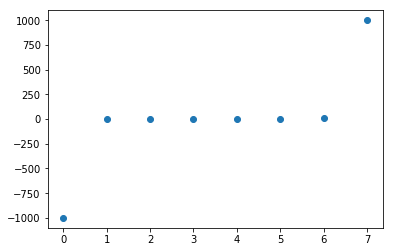

In [7]:
df_ = df.copy()
plt.scatter(df_.index, df_['A'].sort_values(ascending=True).values)
plt.show()

    A
0   0
1   0
2   5
3   2
4   1
5   3
6  10
7  10


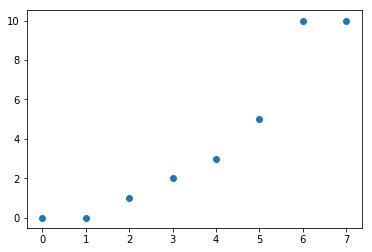

In [8]:
# 調整離群值在適合的範圍內
df_ = df.copy()

df_['A'][df_['A'] > 10] = 10
df_['A'][df_['A'] < 0] = 0
print(df_)

plt.scatter(df_.index, df_['A'].sort_values(ascending=True).values)
plt.show()

    A
0   0
1   5
2   2
3   1
4   3
5  10


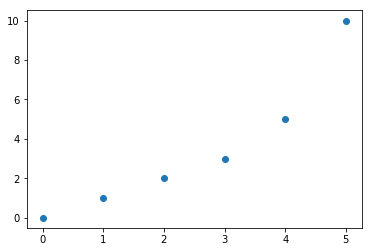

In [9]:
# 捨棄離群值
df_ = df.copy()
df_ = df_[(df_['A'] >= 0) & (df_['A'] <= 10)]
df_.reset_index(drop=True, inplace=True)
print(df_)

plt.scatter(df_.index, df_['A'].sort_values(ascending=True).values)
plt.show()

### 偏態
### log1p降偏態、box-cox降偏態
數據需要是正數<br/>
數據變換後符合正態分佈

                A
count   99.000000
mean    25.951925
std     34.544409
min    -10.000000
25%      8.050000
50%     15.245800
75%     30.672900
max    300.000000


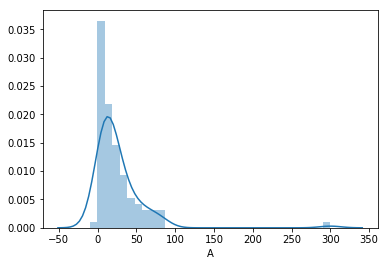

In [10]:
df = DataFrame({'A': [-10., 300., 35.5, 21.075, 31.3875, 7.225, 7.8792, 7.8958, 27.7208, 7.75, 10.5, 82.1708, 52, 7.2292, 8.05, 18, 11.2417, 9.475, 21, 7.8958, 41.5792, 7.8792, 8.05, 15.5, 7.75, 7.25, 71.2833, 7.925, 53.1, 8.05, 8.458, 51.862, 21.075, 11.133, 30.0708, 16.7, 26.55, 8.05, 31.275, 7.8542, 16., 29.125, 13, 18, 7.225, 26, 13, 8.0292, 21.6792, 17.8, 39.6875, 7.8, 76.7292, 26, 61.9792, 35.5, 10.5, 7.2292, 27.75, 46.9, 7.2292, 80, 83.475, 27.9, 27.7208, 15.2458, 10.5, 8.1583, 7.925, 8.6625, 10.5, 46.9, 73.5, 14.4542, 56.4958, 7.65, 7.8958, 8.05, 29, 12.475, 9, 9.5, 7.7875, 47.1, 10.5, 15.85, 34.375, 8.05, 8.05, 8.05, 7.8542, 61.175, 20.575, 7.25, 8.05, 34.6542, 63.3583, 23, 26.]})
print(df.describe())
sns.distplot(df['A'])
plt.show()

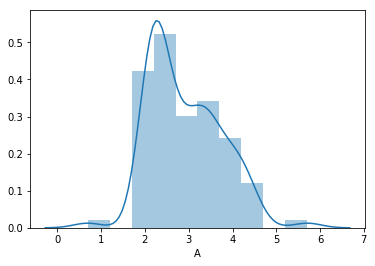

In [11]:
df_ = df.copy()
# if df_['A'].min() <= 0:
#     df_['A'] = df_['A'].apply(lambda x: x + abs(np.min(x)) + 1)
df_['A'][df_['A'] <= 0] = 1

# log1p
df_['A'] = np.log1p(df_['A'])

sns.distplot(df_['A'])
plt.show()

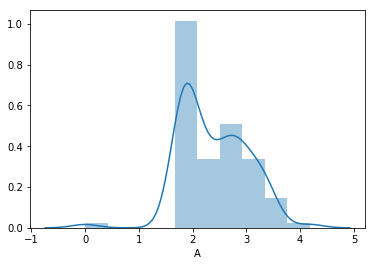

In [12]:
df_ = df.copy()
# if df_['A'].min() <= 0:
#     df_['A'] = df_['A'].apply(lambda x: x + abs(np.min(x)) + 1)
df_['A'][df_['A'] <= 0] = 1

# boxcox
df_['A'] = stats.boxcox(df_['A'])[0]

sns.distplot(df_['A'])
plt.show()

### 處理量綱不一：
### Min-Max標準化、Z-Score標準化、Normalizer歸一化

### Min-Max 標準化（Min Max Scaling）
對原始數據進行線性變換，將特徵值映射成區間為［0，1］的標準值中
### 先數據拆分(train_X, test_X)，再做特徵縮放(Scaling)。或先特徵縮放，再做數據拆分？

In [13]:
df = DataFrame({'A': [6, 7, 5, 6],
                'B': [-10.2, -3.1, 2.8, 9.6],
                'C': [1, 2, 3, 1000]}
              )
print(df)

   A     B     C
0  6 -10.2     1
1  7  -3.1     2
2  5   2.8     3
3  6   9.6  1000


In [14]:
# 0~1 scaling
scaler = MinMaxScaler() # 實例化
array = scaler.fit_transform(df) # fit: 訓練生成min(x)和max(x) # transform: 導出結果
print(array)
print()

[[0.5        0.         0.        ]
 [1.         0.35858586 0.001001  ]
 [0.         0.65656566 0.002002  ]
 [0.5        1.         1.        ]]



In [15]:
# 0~1 scaling
df_ = df.copy()
scaler = MinMaxScaler()
df_[:] = scaler.fit_transform(df_[:])
print(df_)

# -1~1 scaling
df_ = df.copy()
scaler = MinMaxScaler()
df_[:] = (scaler.fit_transform(df_[:])-0.5)*2
print(df_)

     A         B         C
0  0.5  0.000000  0.000000
1  1.0  0.358586  0.001001
2  0.0  0.656566  0.002002
3  0.5  1.000000  1.000000
     A         B         C
0  0.0 -1.000000 -1.000000
1  1.0 -0.282828 -0.997998
2 -1.0  0.313131 -0.995996
3  0.0  1.000000  1.000000


### Z-Score標準化（Standardization）
使數值特徵列的算數平均為0，方差（以及標準差）為1<br/>
標準化後的變量值圍繞0上下波動，大於0說明高於平均水平，小於0說明低於平均水平

In [16]:
df_[:] = scale(df[:])
print(df_)

          A         B         C
0  0.000000 -1.365518 -0.579664
1  1.414214 -0.393570 -0.577349
2 -1.414214  0.414104 -0.575035
3  0.000000  1.344984  1.732048


### 歸一化
使之有unit norm

In [17]:
scaler = Normalizer()
df_[:] = scaler.fit_transform(df[:])
print(df_)

          A         B         C
0  0.505219 -0.858873  0.084203
1  0.884660 -0.391778  0.252760
2  0.772991  0.432875  0.463794
3  0.006000  0.009599  0.999936


## 類別：
## 獨熱編碼、標籤編碼（自然數編碼）
## 均值編碼、計數編碼、低頻編碼
## 雜湊編碼

### 獨熱編碼
沒有明顯的順序（例：紅、黃、藍）<br/>
優點：解決了分類器處理屬性數據的問題。將離散特徵的擴展到了歐式空間，值只有0和1，不同的類型存儲在垂直的空間<br/>
缺點：當類別的數量很多時，特徵空間會變得非常大。一般可以用PCA來減少維度，或改用標籤編碼

In [18]:
df = DataFrame({'Color': ['Red', 'Blue', 'Green', 'Blue', 'Yellow', 'Green']})
print(df)

    Color
0     Red
1    Blue
2   Green
3    Blue
4  Yellow
5   Green


In [19]:
# 獨熱編碼

# get_dummies方法
df_ = df.copy()
df_ = pd.get_dummies(df_)
print(df_)
print()

# OneHotEncoder方法
df_ = df.copy()
ohe = OneHotEncoder()
array = ohe.fit_transform(df_['Color'].values[:,np.newaxis]).toarray()
print(array)

   Color_Blue  Color_Green  Color_Red  Color_Yellow
0           0            0          1             0
1           1            0          0             0
2           0            1          0             0
3           1            0          0             0
4           0            0          0             1
5           0            1          0             0

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


### 標籤編碼（自然數編碼）
特徵本身有順序（例：優秀、良好、合格、不合格）<br/>
優點：消耗內存小，訓練時間快<br/>
缺點：特徵的質量不高

In [20]:
df = DataFrame({'Size': ['XL', 'M', 'XL', 'S', 'L', 'S', 'S']})
print(df)
print()

print(df['Size'].unique())

  Size
0   XL
1    M
2   XL
3    S
4    L
5    S
6    S

['XL' 'M' 'S' 'L']


In [21]:
df_ = df.copy()
for col in df_.columns:
    df_[col] = pd.factorize(df_[col])[0]
print(df_)
print()

df_ = df.copy()
for col in df_.columns:
    le = LabelEncoder()
    df_[col] = le.fit_transform(df_[col])
    print(df_)

   Size
0     0
1     1
2     0
3     2
4     3
5     2
6     2

   Size
0     3
1     1
2     3
3     2
4     0
5     2
6     2


In [22]:
df_ = df.copy()
for col in df_.columns:
    le = LabelEncoder()
    le = le.fit(df_[col])
    df_[col] = le.transform(df_[col])
    print(df_)
    print()
    print(le.inverse_transform(df_['Size']))

   Size
0     3
1     1
2     3
3     2
4     0
5     2
6     2

['XL' 'M' 'XL' 'S' 'L' 'S' 'S']


### 均值編碼
需要高頻出現次數<br/>
優點：符合直覺。類別特徵與目標值有顯著相關<br/>
缺點：容易overfitting。低次數可能受極端值影響

In [23]:
df = DataFrame({'Area': ['E', 'S', 'W', 'N', 'N', 'W', 'S', 'E', 'S', 'W', 'N'],
               'Price': [50, 80, 100, 90, 70, 90, 85, 50, 80, 100, 90]})
print(df)
print()

print(df['Area'].value_counts())

   Area  Price
0     E     50
1     S     80
2     W    100
3     N     90
4     N     70
5     W     90
6     S     85
7     E     50
8     S     80
9     W    100
10    N     90

W    3
N    3
S    3
E    2
Name: Area, dtype: int64


In [24]:
df_ = df.copy()
target = get_target(df_, 'Price')
df_ = drop_cols(df_, ['Price'])

for col in df_.columns:
    df_mean = df.groupby([col])['Price'].mean().reset_index()
    df_mean.columns = [col, f'{col}_mean']
    df_ = pd.merge(df_, df_mean, on=col, how='left')
    df_ = df_.drop([col], axis=1)
print(df_)

    Area_mean
0   50.000000
1   81.666667
2   96.666667
3   83.333333
4   83.333333
5   96.666667
6   81.666667
7   50.000000
8   81.666667
9   96.666667
10  83.333333


### 計數編碼
針對高基數類別特徵的有監督編碼。目標與類別筆數呈高度相關，將筆數本⾝當成特徵<br/>
例：NLP裡的詞頻<br/>
例：家庭地址<br/>
優點：和獨熱編碼相比，節省內存、減少算法計算時間、有效增強模型表現

In [25]:
df = DataFrame({'Area': ['E', 'E', 'E', 'W', 'W', 'W', 'W', 'W', 'W', 'W'],
               'Visitors': [100, 120, 150, 280, 330, 300, 310, 360, 340, 320]})
print(df)
print()

print(df['Area'].value_counts())
print()

  Area  Visitors
0    E       100
1    E       120
2    E       150
3    W       280
4    W       330
5    W       300
6    W       310
7    W       360
8    W       340
9    W       320

W    7
E    3
Name: Area, dtype: int64



In [26]:
print('groupby 方法:\n')
df_ = df.copy()
count_df = df_.groupby(['Area'])['Visitors'].agg({'Area_Count':'size'}).reset_index()
print(count_df)
print()

df_ = pd.merge(df_, count_df, on=['Area'], how='left')
print(df_)

print('\n-----\n')

print('value_counts 方法:\n')

df_ = df.copy()
sr = df_['Area'].value_counts()
print(sr)
print()

count_df = DataFrame({'Area': sr.index.values,
                      'Area_Count':sr.values})
print(count_df)
print()

df_ = pd.merge(df_, count_df, on=['Area'], how='left')
print(df_)

groupby 方法:

  Area  Area_Count
0    E           3
1    W           7

  Area  Visitors  Area_Count
0    E       100           3
1    E       120           3
2    E       150           3
3    W       280           7
4    W       330           7
5    W       300           7
6    W       310           7
7    W       360           7
8    W       340           7
9    W       320           7

-----

value_counts 方法:

W    7
E    3
Name: Area, dtype: int64

  Area  Area_Count
0    W           7
1    E           3

  Area  Visitors  Area_Count
0    E       100           3
1    E       120           3
2    E       150           3
3    W       280           7
4    W       330           7
5    W       300           7
6    W       310           7
7    W       360           7
8    W       340           7
9    W       320           7


/Users/ianfan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


### 低頻編碼
只出現一次的低頻類別，保留其原有的自然數編碼意義不大，不如將所有頻數為1的類別合併到同一個新的類別下<br/>
例：特別偏僻的郊區地址

In [27]:
df = DataFrame({'Cabin': ['A1', 'A2', 'A2', 'A3', 'A1', 'A3', 'A2', 'B5', 'B6', 'A1', 'A2', 'A3', 'A1', 'A3', 'B3', 'B2']})
print(df)
print()

print(df['Cabin'].value_counts())

   Cabin
0     A1
1     A2
2     A2
3     A3
4     A1
5     A3
6     A2
7     B5
8     B6
9     A1
10    A2
11    A3
12    A1
13    A3
14    B3
15    B2

A1    4
A2    4
A3    4
B5    1
B3    1
B6    1
B2    1
Name: Cabin, dtype: int64


In [28]:
df_ = df.copy()

sr = df_['Cabin'].value_counts()
sr = sr[sr.values == 1]
print(sr)
print()

for b in sr.index.values:
    df_['Cabin'].replace({b:'B'}, inplace=True)
print(df_)

B5    1
B3    1
B6    1
B2    1
Name: Cabin, dtype: int64

   Cabin
0     A1
1     A2
2     A2
3     A3
4     A1
5     A3
6     A2
7      B
8      B
9     A1
10    A2
11    A3
12    A1
13    A3
14     B
15     B


### 雜湊 ( Hash )
相異類別的數量非常龐⼤<br/>
在計算空間、時間與鑑別度間取折衷，當其它編碼方式效果更差時使用<br/>
例: 旅客姓名

In [29]:
df = DataFrame({'Name': ['Sam', 'Tom', 'Cindy', 'Penny', 'Anya', 'Hector', 'Eric', 'Doris', 'John', 'Judy', 'Sam', 'Tom', 'Cindy', 'Penny', 'Anya', 'Hector', 'Eric', 'Doris', 'John', 'Judy']})
print(df)

      Name
0      Sam
1      Tom
2    Cindy
3    Penny
4     Anya
5   Hector
6     Eric
7    Doris
8     John
9     Judy
10     Sam
11     Tom
12   Cindy
13   Penny
14    Anya
15  Hector
16    Eric
17   Doris
18    John
19    Judy


In [30]:
df_ = df.copy()

df_['Name_Hash'] = df_['Name'].map(lambda x:hash(x) % 5)
print(df_)

      Name  Name_Hash
0      Sam          4
1      Tom          0
2    Cindy          4
3    Penny          1
4     Anya          0
5   Hector          0
6     Eric          3
7    Doris          3
8     John          3
9     Judy          3
10     Sam          4
11     Tom          0
12   Cindy          4
13   Penny          1
14    Anya          0
15  Hector          0
16    Eric          3
17   Doris          3
18    John          3
19    Judy          3


## 時間：
## 年、月、日、時、分、秒
## 第幾天、第幾週、星期幾
## 日週期、周週期、年週期
## 時長、次數、頻率

In [31]:
# https://docs.python.org/3/library/datetime.html

# %Y 年，四位數 0001, ..., 2019, ..., 9999
# %y 年，兩位數 00, ..., 19, ..., 99
# %m 月，兩位數 01, ..., 12
# %B 月，全名 January, ..., Decenber
# %b 月，縮寫 Jan, ..., Dec
# %d 日，兩位數 01, ..., 31
# %H 時，24時制 00, 01, ..., 23
# %I 時，12時制 12, 1, ..., 11
# %M 分，兩位數 00, ..., 59
# %S 秒，兩位數 00, ..., 59
# %f 毫秒，六位數 000000, ..., 999999
# %p 上下午 AM, PM, am, pm

# %Z 時差，時區名 (empty), UTC, EST, CST
# %z 時差，±HHMM[SS[.ffffff]] (empty), +0000, -0400, +1030, +063415, -030712.345216

# %j 一年中第幾天 001, 002, ..., 366

# %U 一年中第幾週，星期日是每週第一天 00, 01, ..., 53
# %W 一年中第幾週，星期一是每週第一天 00, 01, ..., 53

# %w 一週中星期幾，一位數，星期日是0 0, 1, ..., 6
# %A 一週中星期幾，全名 Sunday, Monday, ..., Saturday
# %a 一週中星期幾，縮寫 Sun, Mon, Sat

# %c 時間格式 Tue Aug 16 21:30:00 1988 
# %X 時間格式 08/16/1988
# %x 時間格式 21:30:00

In [32]:
df = DataFrame(['2011-10-21 23:54:10 UTC', 
                '2015-02-03 10:42:03 UTC', 
                '2014-03-16 18:58:58 UTC', 
                '2009-06-13 16:10:54 UTC', 
                '2014-06-12 03:25:56 UTC'],
              columns=['datetime_full'])
print(df)

             datetime_full
0  2011-10-21 23:54:10 UTC
1  2015-02-03 10:42:03 UTC
2  2014-03-16 18:58:58 UTC
3  2009-06-13 16:10:54 UTC
4  2014-06-12 03:25:56 UTC


In [33]:
# 時間特徵分解方式
df['datetime'] = df['datetime_full'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S UTC'))
df['year'] = df['datetime'].apply(lambda x: datetime.datetime.strftime(x, '%Y')).astype('int64')
df['month'] = df['datetime'].apply(lambda x: datetime.datetime.strftime(x, '%m')).astype('int64')
df['day'] = df['datetime'].apply(lambda x: datetime.datetime.strftime(x, '%d')).astype('int64')
df['hour'] = df['datetime'].apply(lambda x: datetime.datetime.strftime(x, '%H')).astype('int64')
df['minute'] = df['datetime'].apply(lambda x: datetime.datetime.strftime(x, '%M')).astype('int64')
df['second'] = df['datetime'].apply(lambda x: datetime.datetime.strftime(x, '%S')).astype('int64')

print(df[['datetime', 'year', 'month', 'day', 'hour', 'minute', 'second']].head())

             datetime  year  month  day  hour  minute  second
0 2011-10-21 23:54:10  2011     10   21    23      54      10
1 2015-02-03 10:42:03  2015      2    3    10      42       3
2 2014-03-16 18:58:58  2014      3   16    18      58      58
3 2009-06-13 16:10:54  2009      6   13    16      10      54
4 2014-06-12 03:25:56  2014      6   12     3      25      56


In [34]:
# 星期幾
df['day_of_week'] = df['datetime'].apply(lambda x: datetime.datetime.strftime(x, '%w')).astype('int64')

# 第幾周
df['week_of_year'] = df['datetime'].apply(lambda x: datetime.datetime.strftime(x, '%U')).astype('int64')

df[['day_of_week', 'week_of_year']] .head()

,day_of_week,week_of_year
0,5,42
1,2,5
2,0,11
3,6,23
4,4,23


In [35]:
# 日週期
df['day_cycle'] = df['hour']/12 + df['minute']/720 + df['second']/43200
df['day_cycle'] = df['day_cycle'].map(lambda x:math.sin(x*math.pi))

# 周週期
df['day_of_week'] = df['datetime'].apply(lambda x: datetime.datetime.strftime(x, '%w')).astype('int64')
df['week_cycle'] = df['day_of_week']/3.5 + df['hour']/84
df['week_cycle'] = df['week_cycle'].map(lambda x:math.sin(x*math.pi))

# 年週期
df['year_cycle'] = df['month']/6 + df['day']/180
df['year_cycle'] = df['year_cycle'].map(lambda x:math.cos(x*math.pi))

df[['day_cycle', 'week_cycle', 'year_cycle']].head()

,day_cycle,week_cycle,year_cycle
0,-0.025450,-0.804598,0.777146
1,0.333601,0.826239,0.453990
2,-0.967083,0.623490,-0.275637
3,-0.888817,-0.294755,-0.974370
4,0.782427,-0.532032,-0.978148


## 空間：
## 經緯度（經度longitude，緯度latitude）

In [36]:
df = DataFrame({'from_longitude': [-73.990580, -73.988403, -73.989683],
                'from_latitude': [40.761071, 40.715110, 40.729717],
                'to_longitude': [-73.981128, -73.989647, -73.982490],
                'to_latitude': [40.758634, 40.741695, 40.761887]})
print(df)

   from_longitude  from_latitude  to_longitude  to_latitude
0      -73.990580      40.761071    -73.981128    40.758634
1      -73.988403      40.715110    -73.989647    40.741695
2      -73.989683      40.729717    -73.982490    40.761887


In [37]:
# 2d distance
dlon = (df['to_longitude'] - df['from_longitude'])
dlat = df['to_latitude'] - df['from_latitude']
df['distance_2D'] = (dlon**2 + dlat**2)**0.5

# real distance (meter)
def getDistance(lonA, latA, lonB, latB):  
        ra = 6378140  # radius of equator: meter  
        rb = 6356755  # radius of polar: meter  
        flatten = (ra - rb) / ra  # Partial rate of the earth  
        # change angle to radians  
        radLatA = math.radians(latA)  
        radLonA = math.radians(lonA)  
        radLatB = math.radians(latB)  
        radLonB = math.radians(lonB) 
        pA = math.atan(rb / ra * math.tan(radLatA))  
        pB = math.atan(rb / ra * math.tan(radLatB))  
        x = math.acos(math.sin(pA) * math.sin(pB) + math.cos(pA) * math.cos(pB) * math.cos(radLonA - radLonB))  
        c1 = (math.sin(x) - x) * (math.sin(pA) + math.sin(pB))**2 / math.cos(x / 2)**2  
        c2 = (math.sin(x) + x) * (math.sin(pA) - math.sin(pB))**2 / math.sin(x / 2)**2  
        dr = flatten / 8 * (c1 - c2)  
        distance = ra * (x + dr)  
        return distance 
dis_map = map(lambda lon1, lat1, lon2, lat2: getDistance(lon1, lat1, lon2, lat2), df['from_longitude'].values, df['from_latitude'].values, df['to_longitude'].values, df['to_latitude'].values)
df['distance_real'] = Series(list(dis_map))

print(df)

   from_longitude  from_latitude  to_longitude  to_latitude  distance_2D  \
0      -73.990580      40.761071    -73.981128    40.758634     0.009761   
1      -73.988403      40.715110    -73.989647    40.741695     0.026614   
2      -73.989683      40.729717    -73.982490    40.761887     0.032964   

   distance_real  
0     842.759150  
1    2954.095826  
2    3623.728417  


### 排序

# 特徵組合：
### ・數值與數值組合，類別與類別組合，類別與數值組合
### ・統計特徵：平均、中位數、眾數、分位點、最大值、最小值、標準差、方差、頻數
### ・加減乘除、絕對值 |X| 、指數 X^2、對數 logX、比例 X_1 / X_2
### ・max(X_1, X_2)，min(X_1, X_2)，X_1 xor X_2
### ・基因编程，行組合轉換，組合的方式（一元、二元、多元算子）
### ・用決策樹創造新特徵，apply()以及decision_path()方法，在scikit-learn和xgboost

## 統計特徵：平均、中位數、眾數、分位點、最大值、最小值、標準差、方差、頻數

In [38]:
df = DataFrame({'Age': [6, 37, 5, 56, 3, 12, 72, 28, 15, 49],
                'Sex': ['M', 'F', 'F', 'M', 'F', 'F', 'M', 'M', 'M', 'M']})
print(df)

   Age Sex
0    6   M
1   37   F
2    5   F
3   56   M
4    3   F
5   12   F
6   72   M
7   28   M
8   15   M
9   49   M


In [39]:
df_ = df.copy()

# 平均
mean_df = df_.groupby(['Sex'])['Age'].agg({'Age_Sex_Mean':'mean'}).reset_index()
df_ = pd.merge(df_, mean_df, how='left', on=['Sex'])

# 中位數
median_df = df_.groupby(['Sex'])['Age'].agg({'Age_Sex_Median':'median'}).reset_index()
df_ = pd.merge(df_, median_df, how='left', on=['Sex'])

# 眾數
mode_df = df_.groupby(['Sex'])['Age'].apply(lambda x: x.mode()[0]).reset_index()
mode_df.columns = ['Sex', 'Age_Sex_Mode']
df_ = pd.merge(df_, mode_df, how='left', on=['Sex'])

# 分位點
percentile_df = df_.groupby(['Sex'])['Age'].apply(lambda x: np.percentile(x, q = 99)).reset_index()
percentile_df.columns = ['Sex', 'Age_Sex_Percentile']
df_ = pd.merge(df_, percentile_df, how='left', on=['Sex'])

# 最大值
max_df = df_.groupby(['Sex'])['Age'].agg({'Age_Sex_Max':'max'}).reset_index()
df_ = pd.merge(df_, max_df, how='left', on=['Sex'])

# 最小值
min_df = df_.groupby(['Sex'])['Age'].agg({'Age_Sex_Min':'min'}).reset_index()
df_ = pd.merge(df_, min_df, how='left', on=['Sex'])

# 標準差
std_df = df_.groupby(['Sex'])['Age'].agg({'Age_Sex_STD':'std'}).reset_index()
df_ = pd.merge(df_, std_df, how='left', on=['Sex'])

# 方差
var_df = df_.groupby(['Sex'])['Age'].agg({'Age_Sex_Var':'var'}).reset_index()
df_ = pd.merge(df_, var_df, how='left', on=['Sex'])

# 頻數
size_df = df_.groupby(['Sex'])['Age'].agg({'Age_Sex_Size':'size'}).reset_index()
df_ = pd.merge(df_, size_df, how='left', on=['Sex'])

print(df_)

   Age Sex  Age_Sex_Mean  Age_Sex_Median  Age_Sex_Mode  Age_Sex_Percentile  \
0    6   M     37.666667            38.5             6               71.20   
1   37   F     14.250000             8.5             3               36.25   
2    5   F     14.250000             8.5             3               36.25   
3   56   M     37.666667            38.5             6               71.20   
4    3   F     14.250000             8.5             3               36.25   
5   12   F     14.250000             8.5             3               36.25   
6   72   M     37.666667            38.5             6               71.20   
7   28   M     37.666667            38.5             6               71.20   
8   15   M     37.666667            38.5             6               71.20   
9   49   M     37.666667            38.5             6               71.20   

   Age_Sex_Max  Age_Sex_Min  Age_Sex_STD  Age_Sex_Var  Age_Sex_Size  
0           72            6    25.508169   650.666667             6  
1

/Users/ianfan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
/Users/ianfan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  
/Users/ianfan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:22: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
/Users/ianfan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:26: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
/Users/ianfan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: using a dict on a Series for aggre

# 特徵選擇
## 過濾法、集成法、包裝法

## 過濾法（Filter）：
## 相關係數、方差選擇、卡方檢驗、互信息法
自變量與目標變量的關聯<br/>
選定統計數值與設定門檻，刪除低於門檻的特徵<br/>

In [40]:
df = DataFrame({'Age': [10, 37, 17, 56, 33, 12, 72, 28, 15, 49, 16, 27, 19, 46, 23, 32, 22, 88, 55, 80, 10, 37, 17, 56, 33, 12, 72, 28, 15, 49, 16, 27, 19, 46, 23, 32, 22, 88, 55, 80],
                'Country': ['USA', 'SP', 'FR', 'GER', 'IT', 'EN', 'USA', 'SP', 'GER', 'JP', 'FR', 'SP', 'USA', 'SP', 'GER', 'SP', 'JP', 'GER', 'SP', 'IT', 'EN', 'EN', 'EN', 'GER', 'SP', 'JP', 'USA', 'SP', 'SP', 'USA', 'GER', 'SP', 'IT', 'IT', 'GER', 'USA', 'USA', 'GER', 'JP', 'IT'],
                'Sex': ['M', 'F', 'F', 'M', 'F', 'F', 'M', 'M', 'M', 'M', 'M', 'F', 'F', 'M', 'F', 'F', 'M', 'M', 'M', 'M', 'M', 'F', 'F', 'M', 'F', 'F', 'M', 'M', 'M', 'M', 'M', 'F', 'F', 'M', 'F', 'F', 'M', 'M', 'M', 'M'],
                'Survived': [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0]})

print(df.head())

   Age Country Sex  Survived
0   10     USA   M         1
1   37      SP   F         1
2   17      FR   F         1
3   56     GER   M         0
4   33      IT   F         1


In [41]:
df_ = df.copy()
train_Y = get_target(df_, 'Survived')
df_ = simple_encoder(df_)
corr = df_.corr()
df_ = drop_cols(df_, ['Survived'])

print('\n原始特徵 :')
train_X = df_
evaluate_classification(train_X, train_Y)

print('\n相關係數corr:')
print(corr)
high_list = list(corr[(corr['Survived']>0.25) | (corr['Survived']<-0.25)].index)
print(high_list)
high_list.pop(-1)
print(high_list)

print('\n篩選相關係數corr高相關:')
train_X = df_[high_list]
evaluate_classification(train_X, train_Y)


原始特徵 :
GradientBoostingClassifier:
importance:
Sex        0.487819
Age        0.330583
Country    0.181597
dtype: float64

cross_val_score: 0.7797619047619048

LogisticRegression:
cross_val_score: 0.85

相關係數corr:
               Age   Country       Sex  Survived
Age       1.000000  0.108705  0.427797 -0.502132
Country   0.108705  1.000000  0.116741  0.077435
Sex       0.427797  0.116741  1.000000 -0.674453
Survived -0.502132  0.077435 -0.674453  1.000000
['Age', 'Sex', 'Survived']
['Age', 'Sex']

篩選相關係數corr高相關:
GradientBoostingClassifier:
importance:
Sex    0.600638
Age    0.399362
dtype: float64

cross_val_score: 0.7547619047619047

LogisticRegression:
cross_val_score: 0.8277777777777778


## 集成法（Embedded）：
## 基於懲罰項（正則化 L1 Lasso, L2 Ridge）、基於決策樹模型、深度學習
使⽤用機器學習模型，根據擬合後的係數，刪除係數低於門檻的特徵<br/>

In [42]:
df = DataFrame({'Age': [10, 37, 17, 56, 33, 12, 72, 28, 15, 49, 16, 27, 19, 46, 23, 32, 22, 88, 55, 80, 10, 37, 17, 56, 33, 12, 72, 28, 15, 49, 16, 27, 19, 46, 23, 32, 22, 88, 55, 80],
                'Country': ['USA', 'SP', 'FR', 'GER', 'IT', 'EN', 'USA', 'SP', 'GER', 'JP', 'FR', 'SP', 'USA', 'SP', 'GER', 'SP', 'JP', 'GER', 'SP', 'IT', 'EN', 'EN', 'EN', 'GER', 'SP', 'JP', 'USA', 'SP', 'SP', 'USA', 'GER', 'SP', 'IT', 'IT', 'GER', 'USA', 'USA', 'GER', 'JP', 'IT'],
                'Sex': ['M', 'F', 'F', 'M', 'F', 'F', 'M', 'M', 'M', 'M', 'M', 'F', 'F', 'M', 'F', 'F', 'M', 'M', 'M', 'M', 'M', 'F', 'F', 'M', 'F', 'F', 'M', 'M', 'M', 'M', 'M', 'F', 'F', 'M', 'F', 'F', 'M', 'M', 'M', 'M'],
                'Survived': [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0]})

print(df.head())

   Age Country Sex  Survived
0   10     USA   M         1
1   37      SP   F         1
2   17      FR   F         1
3   56     GER   M         0
4   33      IT   F         1


In [43]:
df_ = df.copy()
train_Y = get_target(df_, 'Survived')
df_ = simple_encoder(df_)
df_ = drop_cols(df_, ['Survived'])

train_X = df_
print('\n相關係數L1:')
L1_Reg = Lasso(alpha=0.03) # 調整不同的正規化程度，使得⼀部分的特徵係數為０，刪除係數為０的特徵
L1_Reg.fit(train_X, train_Y)
print(L1_Reg.coef_)

print('\n篩選相關係數L1:')
L1_mask = list((L1_Reg.coef_>0) | (L1_Reg.coef_<-0))
L1_list = list(compress(list(df_), list(L1_mask)))
print(L1_list)

train_X = df_[L1_list]
evaluate_classification(train_X, train_Y)


相關係數L1:
[-0.12411953  0.         -0.5310723 ]

篩選相關係數L1:
['Age', 'Sex']
GradientBoostingClassifier:
importance:
Sex    0.600589
Age    0.399411
dtype: float64

cross_val_score: 0.7547619047619047

LogisticRegression:
cross_val_score: 0.8277777777777778


## 包裝法（Wrapper）：
## 遞歸特徵消除法
通過目標函數（AUC/MSE）來決定是否加入一個變量<br/>
完全搜索、啟發式搜索、隨機搜索<br/>
根據目標函數，逐步加入特徵或刪除特徵<br/>

## 使用 featex 選擇

In [44]:
df = DataFrame({'Age': [10, 37, 17, 56, 33, 12, 72, 28, 15, 49, 16, 27, 19, 46, 23, 32, 22, 88, 55, 80, 10, 37, 17, 56, 33, 12, 72, 28, 15, 49, 16, 27, 19, 46, 23, 32, 22, 88, 55, 80],
                'Sex': ['M', 'F', 'F', 'M', 'F', 'F', 'M', 'M', 'M', 'M', 'M', 'F', 'F', 'M', 'F', 'F', 'M', 'M', 'M', 'M', 'M', 'F', 'F', 'M', 'F', 'F', 'M', 'M', 'M', 'M', 'M', 'F', 'F', 'M', 'F', 'F', 'M', 'M', 'M', 'M'],
                'Buy': [10, 250, 50, 0, 180, 0, 300, 90, 0, 320, 50, 140, 40, 280, 190, 150, 0, 650, 170, 500, 10, 250, 50, 0, 180, 0, 300, 90, 0, 320, 50, 140, 40, 280, 190, 150, 0, 650, 170, 500]})

df_ = df.copy()
# df_ = simple_encoder(df)
train_X = df_.iloc[:15]
test_X = df_.iloc[15:]

                                            Plots for Age                                             
                                           Train data plots                                           


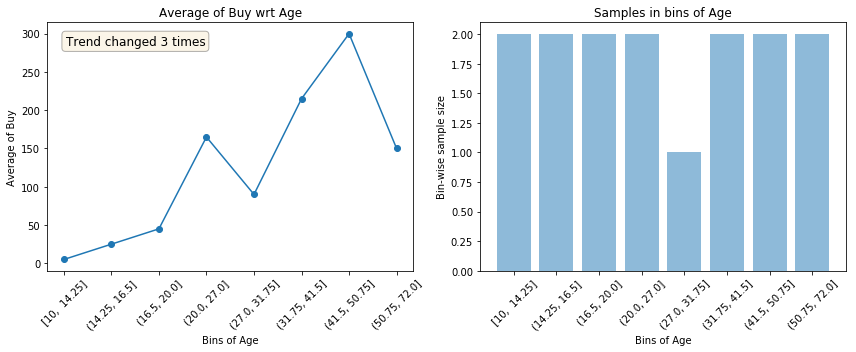

                                           Test data plots                                            


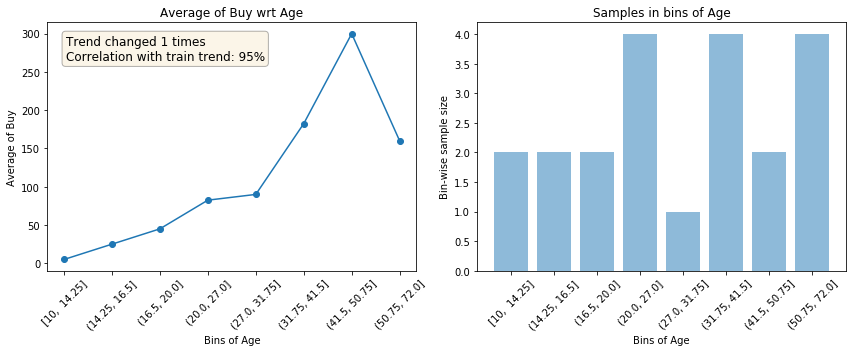

--------------------------------------------------------------------------------------------------------------




In [45]:
get_univariate_plots(data=train_X, data_test=test_X, target_col='Buy', features_list=['Age'], bins=8)

In [46]:
stats = get_trend_stats(data=train_X, target_col='Buy', data_test=test_X)
print(stats)

Categorical features ['Sex'] ignored. Categorical features not supported yet.
Returning stats for all numeric features
  Feature  Trend_changes  Trend_changes_test  Trend_correlation
0     Age              5                   3           0.969647


## 降維：PCA，LDA

# 特徵評估：
## ・cross_val_score
## ・feature importance

In [47]:
df = DataFrame({'Name': ['Sam', 'James', 'Cindy', 'Penny', 'Tom'],
                'Time': [60, 30, 50, 50, 60],
                'Score': [80, 30, 50, 90, 60],
                'Pass':[1, 0, 0, 1, 1]})
print(df)

    Name  Time  Score  Pass
0    Sam    60     80     1
1  James    30     30     0
2  Cindy    50     50     0
3  Penny    50     90     1
4    Tom    60     60     1


In [48]:
train_Y = get_target(df, 'Pass')
df_ = drop_cols(df, ['Pass', 'Name'])
print()
train_X = simple_encoder(df_)
print()
evaluate_classification(train_X, train_Y)



GradientBoostingClassifier:
importance:
Score    1.0
Time     0.0
dtype: float64

cross_val_score: 0.5833333333333333

LogisticRegression:
cross_val_score: 0.75


In [49]:
train_Y = get_target(df, 'Score')
df_ = drop_cols(df, ['Score', 'Name'])
print()
train_X = simple_encoder(df_)
print()
evaluate_regression(train_X, train_Y)



GradientBoostingRegressor:
importance:
Pass    0.775641
Time    0.224359
dtype: float64



## 葉編碼(leaf encoding)
分類型特徵優化<br/>
目的是重新標記資料，以擬合後的樹狀模型分歧條件，將資料離散化，這樣比人為判斷條件更精準，更符合資料的分布情形<br/>
葉編碼編完後，因為特徵數量量較多，通常搭配邏輯斯回歸或者分解機做預測，其他模型較不適合

In [50]:
df = DataFrame({'A': [47.1, 10.5, 15.85, 34.375, 8.05, 8.05, 8.05, 7.8542, 61.175, 20.575, 7.25, 8.05, 34.6542, 63.3583, 23, 26., 47.1, 10.5, 15.85, 34.375, 8.05, 8.05, 8.05, 7.8542, 61.175, 20.575, 7.25, 8.05, 34.6542, 63.3583, 23, 26.],
                'B': [17.1, 30.5, 55.85, 94.375, 18.05, 28.05, 38.05, 27.8542, 11.175, 10.575, 27.25, 38.05, 14.6542, 13.3583, 13, 26., 17.1, 30.5, 55.85, 94.375, 18.05, 28.05, 38.05, 27.8542, 11.175, 10.575, 27.25, 38.05, 14.6542, 13.3583, 13, 26.],
                'C': [1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]})
print(df.head())

        A       B  C
0  47.100  17.100  1
1  10.500  30.500  0
2  15.850  55.850  1
3  34.375  94.375  1
4   8.050  18.050  0


In [51]:
df_ = df.copy()
train_Y = get_target(df_, 'C')
df_ = drop_cols(df_, ['C'])
df_ = simple_encoder(df_)
train_X = df_

train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y, test_size=0.5)
train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.5)

/Users/ianfan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


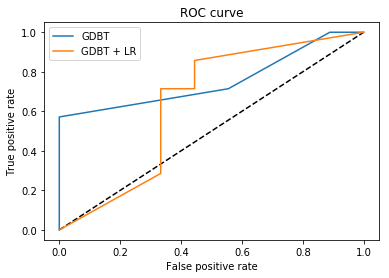

In [52]:
# 梯度提升樹調整參數並擬合後, 再將葉編碼 (*.apply) 結果做獨熱 / 邏輯斯迴歸
gdbt = GradientBoostingClassifier(subsample=0.93, n_estimators=320, min_samples_split=0.1, min_samples_leaf=0.3, 
                                  max_features=2, max_depth=4, learning_rate=0.16)
gdbt.fit(train_X, train_Y)

onehot = OneHotEncoder()
onehot.fit(gdbt.apply(train_X)[:, :, 0])

lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(onehot.transform(gdbt.apply(val_X)[:, :, 0]), val_Y)

# 將梯度提升樹+葉編碼+邏輯斯迴歸結果輸出
pred_gdbt_lr = lr.predict_proba(onehot.transform(gdbt.apply(test_X)[:, :, 0]))[:, 1]
fpr_gdbt_lr, tpr_gdbt_lr, _ = roc_curve(test_Y, pred_gdbt_lr)

# 將梯度提升樹結果輸出
pred_gdbt = gdbt.predict_proba(test_X)[:, 1]
fpr_gdbt, tpr_gdbt, _ = roc_curve(test_Y, pred_gdbt)

# 將結果繪圖
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_gdbt, tpr_gdbt, label='GDBT')
plt.plot(fpr_gdbt_lr, tpr_gdbt_lr, label='GDBT + LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

/Users/ianfan/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


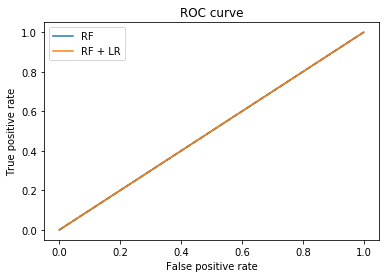

In [53]:
## 隨機森林擬合後, 再將葉編碼 (*.apply) 結果做獨熱 / 邏輯斯迴歸
rf = RandomForestClassifier(n_estimators=20, min_samples_split=10, min_samples_leaf=5, 
                            max_features=2, max_depth=3, bootstrap=True)
rf.fit(train_X, train_Y)

ohe = OneHotEncoder()
ohe.fit(rf.apply(train_X))

lr = LogisticRegression(solver='lbfgs', max_iter=1000)
lr.fit(ohe.transform(rf.apply(val_X)), val_Y) # 隨機森林的葉編碼(.apply)不需要加上[:, :, 0], 直接用rf.apply()調用即可)

# 將隨機森林+葉編碼+邏輯斯迴歸結果輸出
pred_rf_lr = lr.predict_proba(ohe.transform(rf.apply(test_X)))[:, 1]
fpr_rf_lr, tpr_rf_lr, _ = roc_curve(test_Y, pred_rf_lr)

# 將隨機森林結果輸出
pred_rf = rf.predict_proba(test_X)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(test_Y, pred_rf)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_rf_lr, tpr_rf_lr, label='RF + LR')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

# 數據洩露（Data Leakage）

在數據挖掘中，數據洩露（leakage）指的是：本來不應該出現在X里的、和目標y有關的數據，出現在了X中。如此一來，機器學習算法就會有好到不真實的表現

## 數據洩露可以分為兩大類：
### ・由於自己的疏忽，在交叉驗證、訓練過程中，產生的數據洩露
在模型的訓練、選擇和交叉驗證時，我們只能接觸訓練集<br/>
例：測試集數據被洩露到訓練集
未來的信息被洩露到過去<br/>
例：y是「病人是否患有癌症」，但是X包括了「病人是否接受腫瘤切除手術」
### ・在數據競賽中，找到了理論上不能使用（但是也沒有明令禁止）的額外數據，從而提升分數
例：反向工程「隨機的」用戶編碼，得出用戶的真名<br/>
例：已知坐標，利用geocoder類型的服務推出所在城市<br/>

# 經驗

## 支付流水：
反映出客戶的經濟實力和消費習慣<br/>
賬戶間的複雜交易關係和異常金額時間地點的支付行為，都可以在反欺詐場景中應用，視為團伙作案或者反洗錢的重要指標<br/>
### ・支付編號：日/周/月支付頻率
### ・支付帳戶：來往賬戶數量、帳戶間關聯圖譜
### ・支付時間：最早、最近的支付時間、支付時段分佈
### ・支付金額：支付金額總和/平均值/最大值
### ・支付地點：地點類型分佈、較頻繁地點
### ・支付目的：較頻繁的目的
### ・支付狀態：支付成功/失敗次數

## 財富管理：
體現出客戶的資金儲備和購買偏好。對風險偏好較低或較高的客服推薦不同金融產品
### ・申購編號：申購頻率
### ・申購時間：最早、最近的申購時間
### ・申購金額：申購金額總和/平均值/最大值
### ・產品類型：產品類型分佈、產品偏好
### ・產品收益：收益總和、日均收益
### ・持倉金額：當前持倉、歷史最大持倉、日均持倉

## 貸款信息：
各家資方信貸數據的共享。基於一個客戶在各個平台上的貸款申請、提現、還款信息，可以刻畫出這個客戶的還款意願和徵信表現，從而為其下一次的信貸申請決策提供建議。多個平台申請和在貸以及當前有貸款發生90天以上逾期的用戶，都會被其他平台列入自動拒絕的名單
### ・申請編號：申請頻率
### ・申請時間：最早、最近的申請時間
### ・授信金額：授信金額總和/平均值/最大值
### ・提現金額：授信金額總和/平均值/最大值、提現比例
### ・資方類型：資方個數
### ・申請狀態：申請通過/拒絕次數
### ・還款時間：提前結清/正常/預期總天數
### ・預期金額：逾期金額總和/最大值
### ・還款狀態：已結清/正常/逾期比數

## App登入：
從SDK埋點獲取的各類app登錄數據中，我們可以分析出用戶在每個app上的停留時間，從而側面瞭解這個用戶的興趣愛好，甚至預測用戶的年齡和性別
### ・登入編號：日/周/月登錄頻率
### ・登入時間：最早、最近的登入時間、時段分佈
### ・操作類型：操作類型分佈、業務線偏好

## 電商流水
從電商公司豐富的訂單流水數據中，可以挖掘出較為完整的客戶畫像。客戶Alice近一年內購買頻繁，但是平均單筆訂單金額較低，通常集中在生活用品以及水果生鮮，可以推斷出Alice應該是一位家庭婦女；而客戶Ben消費總金額較高，購買過車飾類產品，收貨地址集中在辦公場所，則大概率Ben是有車一族的白領青年
### ・訂單編號：當月/近3個月/近6個月/近12個月訂單總數
### ・sku編號：當月/近3個月/近6個月/近12個月商品總數
### ・訂單時間：最早\最近的訂單時間、近12個月有消費月份數
### ・訂單金額：當月/近3個月/近6個月/近12個月訂單總金額/訂單最大金額/平均單筆訂單金額
### ・訂單狀態：當月/近3個月/近6個月/近12個月實付金額占比
### ・分期標誌：當月/近3個月/近6個月/近12個月分期訂單數佔比



## 收貨地址：
在信貸風控場景中，通常近一年內地址數量較少、地址穩定性高的用戶，貸款逾期風險更低；而對於地址變動頻繁或者不良紀錄的用戶，建議拒絕貨前申請，或者把這些收貨地址放到貸後催收之中
### ・訂單編號：當月/近3個月/近6個月/近12個月使用收貨地址個數
### ・收貨地址：收貨地址使用時長
### ・地址類型：城市等級、區域等級、地址穩定性、是否有不良紀錄

## 運營商信息：
數據市場上比較常見的第三方數據源，可以用作各個場景下的身份證、姓名、手機號的三要素核驗，以及利用在網時長和在網狀態判斷一個用戶是否有欺詐風險。除去上面整理的簡單底層特徵，在實際工作中數據分析師和算法工程師們還需要針對不同的業務場景，利用規則和模型構造一些複雜特徵
### ・通話數據：當月/近3個月/近6個月/近12個月通話量/通話次數、撥出/撥入/漫遊通話量/通話次數、通話時段分佈
### ・流量數據：當月/近3個月/近6個月/近12個月流量、流量時段分佈
### ・帳單訊息：當月/近3個月/近6個月/近12個月帳單金額平均值/最大值、當月儲值金額、當前欠費金額
### ・客戶訊息：上網時長、在網狀態、名下手機號碼數量/上網設備數量/設備品牌
### ・網路訪問：個類別App訪問總次數/總時長/活躍天數、App類別分佈